In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
#https://www.kaggle.com/code/zacharyzhangg/learning-scikit-learn-continually-updated

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

2022-11-03 16:39:48,728 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2022-11-03 16:39:50,465 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2022-11-03 16:39:52,106 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2022-11-03 16:39:54,042 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


In [4]:
n_samples, h, w = lfw_people.images.shape
n_samples, h, w

(1288, 50, 37)

In [5]:
X = lfw_people.data
n_features = X.shape[1]
n_features

1850

In [6]:
X.shape

(1288, 1850)

In [7]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): 
# unsupervised feature extraction / dimensionality reduction
n_components = 150

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
         whiten=True).fit(X_train)
print("Done in %.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
             'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Done in 0.089s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [10]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

              precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.83      0.87      0.85        60
           2       0.86      0.67      0.75        27
           3       0.83      0.98      0.90       146
           4       0.95      0.80      0.87        25
           5       1.00      0.53      0.70        15
           6       1.00      0.78      0.88        36

    accuracy                           0.86       322
   macro avg       0.89      0.74      0.80       322
weighted avg       0.87      0.86      0.85       322

[[  7   1   0   5   0   0   0]
 [  1  52   2   5   0   0   0]
 [  1   1  18   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   4  20   0   0]
 [  0   4   0   2   1   8   0]
 [  0   1   1   6   0   0  28]]


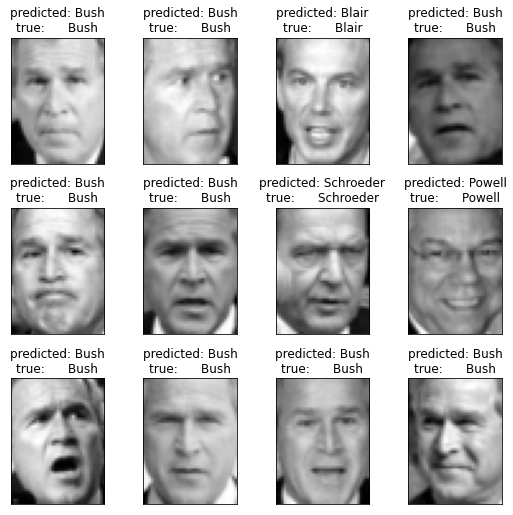

In [11]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8*n_col, 2.4*n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row*n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(title(y_pred, y_test, target_names, i), size=12)
        plt.xticks(())
        plt.yticks(())
        
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

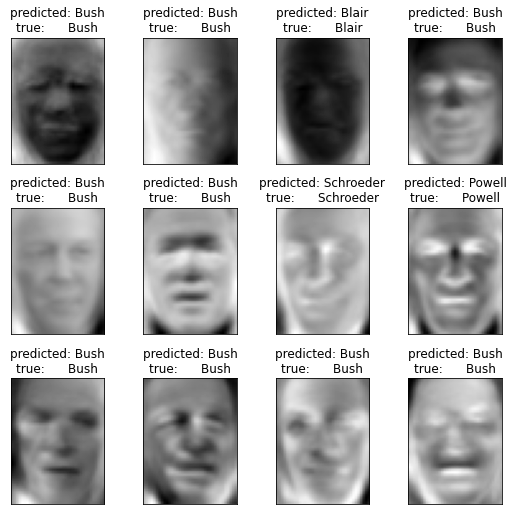

In [12]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]

plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()